In [177]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score
from google.colab import drive

In [178]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [179]:
close = np.load("/content/drive/MyDrive/close_mean_ts_by_network.npy")
open = np.load("/content/drive/MyDrive/open_mean_ts_by_network.npy")

In [180]:
close.shape, open.shape # [networks, subjects, time]

((14, 84, 120), (14, 84, 120))

In [181]:
data = np.concatenate((close, open), axis=1)
data = torch.tensor(data).float()
data = data.reshape((168, 14, 120))

labels = [1] * close.shape[1] + [0] * open.shape[1] # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()

dataset = TensorDataset(data, labels)
train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=44)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3, random_state=44)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [182]:
train_ratio = 0
for i in range(len(train_dataset)):
    if train_dataset[i][1].item() == 0:
        train_ratio += 1
print(train_ratio / len(train_dataset))

test_ratio = 0
for i in range(len(test_dataset)):
    if test_dataset[i][1].item() == 0:
        test_ratio += 1
print(test_ratio / len(test_dataset))

0.5308641975308642
0.5490196078431373


In [183]:
len(train_dataset), len(test_dataset), len(val_dataset)

(81, 51, 36)

In [184]:
train_dataset[0][0].shape, train_dataset[0][1].shape

(torch.Size([14, 120]), torch.Size([]))

In [185]:
class TimeSeriesCNN(nn.Module):
    def __init__(self, input_channels, hidden_size, dropout=0.1):
        super(TimeSeriesCNN, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.input_channels = input_channels

        for _ in range(input_channels):
            self.conv_layers.append(nn.Sequential(
                nn.Conv1d(1, 128, kernel_size=5),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
                nn.Conv1d(128, 64, kernel_size=5),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
                nn.Conv1d(64, 32, kernel_size=5),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
                nn.Conv1d(32, 16, kernel_size=5),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
            ))

        self.fc1 = nn.Linear(1120, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        conv_outs = []
        for i in range(self.input_channels):
            conv_out = self.conv_layers[i](x[:, i:i+1, :])
            conv_outs.append(conv_out)
        conv_out = torch.cat(conv_outs, dim=1)
        conv_out = conv_out.view(conv_out.size(0), -1)
        fc_out = F.relu(self.fc1(conv_out))
        output = torch.sigmoid(self.fc2(fc_out))
        return output.squeeze(1)

In [208]:
input_channels = close.shape[0]
model = TimeSeriesCNN(input_channels, 128)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)

In [209]:
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
train_roc_auc = []
test_roc_auc = []
val_losses = []

def train(model):
    num_epochs = 30
    print_every = 5
    patience = 4
    epochs_increasing = 0
    last_loss = 100000
    for epoch in range(num_epochs):
        running_loss = 0.0
        y_train_true = []
        y_train_pred_proba = []

        for inputs, labels in train_loader:
            model.train()
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            y_train_true.extend(labels.cpu().tolist())
            y_train_pred_proba.extend(output.cpu().tolist())
            running_loss += loss.item()

        running_loss /= len(train_loader)
        y_train_true = torch.Tensor(y_train_true)
        y_train_pred_proba = torch.Tensor(y_train_pred_proba)
        train_losses.append(running_loss)
        train_pred = (torch.Tensor(y_train_pred_proba) > 0.5).float()
        accuracy = (train_pred == y_train_true).sum().item() / y_train_true.shape[0]
        train_accuracy.append(accuracy)
        roc_auc = roc_auc_score(y_train_true, y_train_pred_proba)
        train_roc_auc.append(roc_auc)

        test_loss = 0.0
        y_test_true = []
        y_test_pred_proba = []
        for inputs, labels in test_loader:
            model.eval()
            output = model(inputs)
            loss = criterion(output, labels)
            test_loss += loss.item()
            y_test_true.extend(labels.cpu().tolist())
            y_test_pred_proba.extend(output.cpu().tolist())

        test_loss /= len(test_loader)
        y_test_true = torch.Tensor(y_test_true)
        y_test_pred_proba = torch.Tensor(y_test_pred_proba)
        test_losses.append(test_loss)
        test_pred = (torch.Tensor(y_test_pred_proba) > 0.5).float()
        accuracy = (test_pred == y_test_true).sum().item() / y_test_true.shape[0]
        test_accuracy.append(accuracy)
        roc_auc = roc_auc_score(y_test_true, y_test_pred_proba)
        test_roc_auc.append(roc_auc)

        val_loss = 0.0
        for inputs, labels in val_loader:
            model.eval()
            output = model(inputs)
            loss = criterion(output, labels)
            val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        if val_loss > last_loss:
            epochs_increasing += 1
            if epochs_increasing >= patience:
                print('Early stopping!\n')
                return
        else:
            epochs_increasing = 0

        last_loss = val_loss
        if epoch % print_every == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train loss: {running_loss:.4f}, Test loss: {test_loss:.4f}")

Иногда early stopping может сработать очень рано, но всё должно работать, если просто переинициализировать модель и перезапустить обучение

In [210]:
train(model)

Epoch 1/30, Train loss: 41.7441, Test loss: 37.5737
Epoch 6/30, Train loss: 41.6367, Test loss: 36.3366
Epoch 11/30, Train loss: 40.3961, Test loss: 37.2341
Epoch 16/30, Train loss: 39.7697, Test loss: 36.9921
Epoch 21/30, Train loss: 39.0173, Test loss: 35.1180
Epoch 26/30, Train loss: 38.8663, Test loss: 34.9432


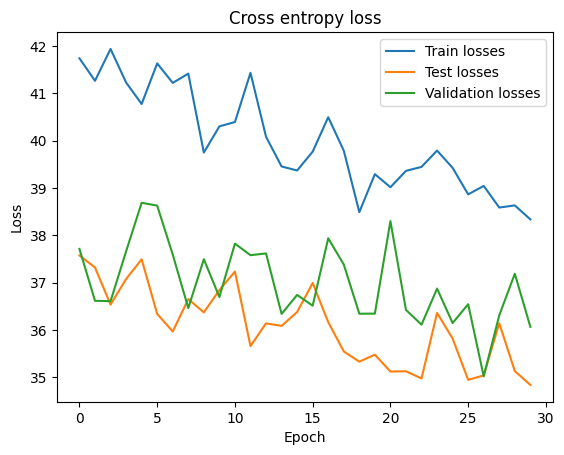

In [211]:
plt.plot(train_losses, label='Train losses')
plt.plot(test_losses, label='Test losses')
plt.plot(val_losses, label='Validation losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross entropy loss')
plt.legend()
plt.show()

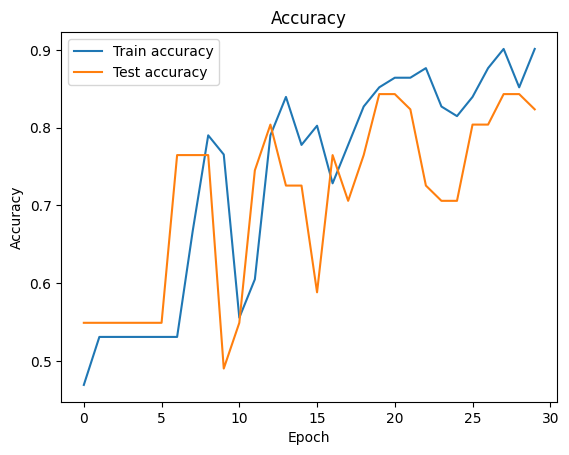

In [212]:
plt.plot(train_accuracy, label='Train accuracy')
plt.plot(test_accuracy, label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

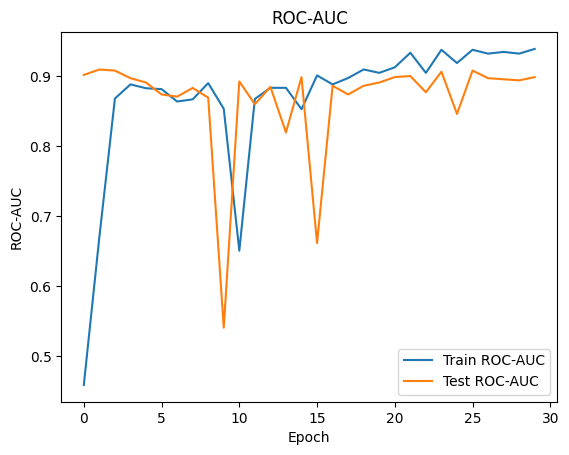

In [213]:
plt.plot(train_roc_auc, label='Train ROC-AUC')
plt.plot(test_roc_auc, label='Test ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC')
plt.legend()
plt.show()